### Train a BERT Classifier 
Code is based on https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb and https://github.com/reascr/MA_Speech_and_Language_Processing/blob/main/Deep_Learning_with_Python/DeepLearning2022-Project.ipynb (De Rosa Palmini & Schröter 2022).

In [1]:
#pip install -U sentence-transformers
from transformers import BertTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes/train.csv')
df_val = pd.read_csv('/kaggle/input/dataframes/val.csv')
df_test = pd.read_csv('/kaggle/input/dataframes/test.csv')
df_train.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR
0,39821-17strada.jpg,"In the final period, which saw [PAINTER] focus...",TIZIANO Vecellio
1,39706-08urbin.jpg,The Venus of Urbino was painted for Guidobaldo...,TIZIANO Vecellio
2,18275-0814grec.jpg,The painting represents the thirteenth-century...,"GRECO, El"
3,10341-2bocca1.jpg,"La Bocca della Verit&#224; (in English, ""the M...","CRANACH, Lucas the Elder"
4,39730-6perseus.jpg,This painting is one of the six 'poesie' paint...,TIZIANO Vecellio


In [3]:
max_length = 500
#input_ids = np.zeros((len(df_4), max_length)) # number of images, max_length tokens
#att_masks = np.zeros((len(df_4), max_length))

# Prepare input data
input_ids_train = np.zeros((len(df_train), max_length))
att_masks_train = np.zeros((len(df_train), max_length))

input_ids_val = np.zeros((len(df_val), max_length))
att_masks_val = np.zeros((len(df_val), max_length))

input_ids_test = np.zeros((len(df_test), max_length))
att_masks_test = np.zeros((len(df_test), max_length))



def encode_text(df, ids, attention_masks, tokenizer):
    '''
    This function iterates over all rows in a dataframe. Using the encode_plus() method of the Tokenizer object,
    it encodes the text data and stores the ids and attention masks in numpy arrays. The tqdm function is used to display a progress bar.
    '''
    for i, text in tqdm(enumerate(df['DESCRIPTION'])):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=500,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized.input_ids
        attention_masks[i, :] = tokenized.attention_mask
    return ids, attention_masks

# fill the numpy arrays inititalized with zeros with the input ids and attention masks for the dataset
#input_ids, att_masks = encode_text(comments_df, input_ids, att_masks, tokenizer)

# Encode train data
input_ids_train, att_masks_train = encode_text(df_train, input_ids_train, att_masks_train, tokenizer)

# Encode validation data
input_ids_val, att_masks_val = encode_text(df_val, input_ids_val, att_masks_val, tokenizer)

# Encode test data
input_ids_test, att_masks_test = encode_text(df_test, input_ids_test, att_masks_test, tokenizer)


0it [00:00, ?it/s]2024-05-21 09:47:58.867709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:47:58.867767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:47:58.869260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
1962it [00:08, 221.00it/s]
109it [00:00, 344.58it/s]
109it [00:00, 325.48it/s]


In [4]:
# Prepare labels
from keras.utils import to_categorical

label_encoder = LabelEncoder()

label_encoder.fit(df_train['AUTHOR'])

# Apply label encoder to transform labels into integers
labels_train = label_encoder.transform(df_train['AUTHOR'])
labels_val = label_encoder.transform(df_val['AUTHOR'])
labels_test = label_encoder.transform(df_test['AUTHOR'])

labels_train = to_categorical(np.asarray(labels_train))
labels_val = to_categorical(np.asarray(labels_val))
labels_test = to_categorical(np.asarray(labels_test))


In [5]:
import tensorflow as tf
# create a data pipeline for feeding the encoded input sequences, attention masks and label data into the model
train_dataset = tf.data.Dataset.from_tensor_slices((input_ids_train, att_masks_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((input_ids_val, att_masks_val, labels_val))
test_dataset = tf.data.Dataset.from_tensor_slices((input_ids_test, att_masks_test, labels_test))
train_dataset.take(1) # retrieve first sample in data set and check its shape and content

<_TakeDataset element_spec=(TensorSpec(shape=(500,), dtype=tf.float64, name=None), TensorSpec(shape=(500,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [6]:
# creating dictionaries
def SentimentDatasetMapFunction(input_ids, att_masks, labels):
    '''This function maps the encoded input sequences, attention masks and labels to a format required by the input layer of the BERT model.
    It returns a dictionary with two keys (input_ids and attention_mask) that can be later used as input to the map method of a tf.data.Dataset object.'''
    return {
        'input_ids': input_ids,
        'attention_mask': att_masks
    }, labels

In [7]:
# transform data according to the SentimentDataSetMapfunction (required format for tensorflow dataset)
#converting to required format for tensorflow dataset
# Map datasets
train_dataset = train_dataset.map(SentimentDatasetMapFunction)
val_dataset = val_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
train_dataset.take(0)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(500,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(500,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [8]:
'''# random shuffling of the data and setting the batch size to 16
#dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
train_dataset = train_dataset.batch(16, drop_remainder=True)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)'''

'# random shuffling of the data and setting the batch size to 16\n#dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)\ntrain_dataset = train_dataset.batch(16, drop_remainder=True)\nval_dataset = val_dataset.batch(16)\ntest_dataset = test_dataset.batch(16)'

In [9]:
batch_size=16
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [10]:
train_dataset = train_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))
val_dataset = val_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))
test_dataset = test_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))

In [11]:
'''# split the dataset into train, val, and test sets # NOT NEEDED!!!!

p_train = 0.8
p_val = 0.1
p_test = 0.1

num_samples = len(df_4)//16
train_size = int(num_samples * p_train)
val_size = int(num_samples * p_val)

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)'''

'# split the dataset into train, val, and test sets # NOT NEEDED!!!!\n\np_train = 0.8\np_val = 0.1\np_test = 0.1\n\nnum_samples = len(df_4)//16\ntrain_size = int(num_samples * p_train)\nval_size = int(num_samples * p_val)\n\ntrain_dataset = dataset.take(train_size)\nremaining_dataset = dataset.skip(train_size)\nval_dataset = remaining_dataset.take(val_size)\ntest_dataset = remaining_dataset.skip(val_size)'

In [12]:
# loading the bert-uncased model
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# freeze weights of BERT's layers (prevent weights from pre-trained BERT model from updating)
bert = model.bert

for layer in bert.submodules:
    layer.trainable = False

In [14]:
# Set random seeds for reproducibility TRY TEN DIFFERENT PER MODEL
# np.random.seed(42)
#tf.random.set_seed(42)

# defining the two input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(500,), name='input_ids', dtype='int32')
att_masks = tf.keras.layers.Input(shape=(500,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=att_masks)[1] # getting the pooled output layer

intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(intermediate_layer)

bert_model = tf.keras.Model(inputs=[input_ids, att_masks], outputs=output_layer)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 500, 7                                       

In [15]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5) # increase learning rate?
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [16]:
bert_model.compile(optimizer=optim, loss=loss_func, metrics=['acc'])

In [17]:
# train model
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


I0000 00:00:1716284956.685653     415 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 [==============================] - 145s 816ms/step - loss: 2.2785 - acc: 0.1692 - val_loss: 2.3082 - val_acc: 0.0642
Epoch 2/10
123/123 [==============================] - 89s 727ms/step - loss: 2.2237 - acc: 0.1957 - val_loss: 2.2849 - val_acc: 0.1009
Epoch 3/10
123/123 [==============================] - 89s 725ms/step - loss: 2.1916 - acc: 0.2176 - val_loss: 2.2637 - val_acc: 0.1193
Epoch 4/10
123/123 [==============================] - 89s 725ms/step - loss: 2.1773 - acc: 0.2238 - val_loss: 2.2434 - val_acc: 0.1193
Epoch 5/10
123/123 [==============================] - 90s 732ms/step - loss: 2.1559 - acc: 0.2401 - val_loss: 2.2324 - val_acc: 0.1193
Epoch 6/10
123/123 [==============================] - 89s 725ms/step - loss: 2.1411 - acc: 0.2421 - val_loss: 2.2153 - val_acc: 0.1743
Epoch 7/10
123/123 [==============================] - 89s 724ms/step - loss: 2.1237 - acc: 0.2615 - val_loss: 2.2032 - val_acc: 0.1651
Epoch 8/10
123/123 [==============================] - 89s 725ms/s

In [18]:
# evaluate model on test data
test_loss, test_acc = bert_model.evaluate(test_dataset, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 2.0298259258270264
Test accuracy: 0.29357796907424927


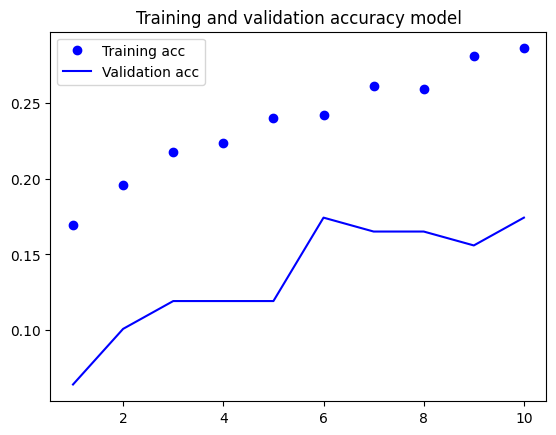

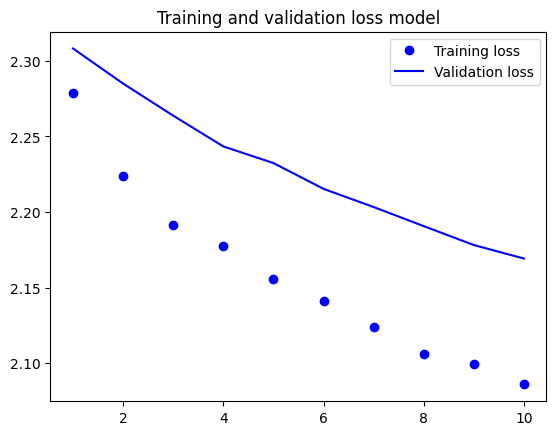

In [19]:
# plotting the accuracy and loss of the training and validation data for the BERT model (cf. Chollet 2018: 192)

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss model')
plt.legend()

plt.show()

In [20]:
'''# Load data frames
import pandas as pd

# Assuming you have train, val, and test dataframes already loaded
# df_train = pd.read_csv('/path/to/train.csv')
# df_val = pd.read_csv('/path/to/val.csv')
# df_test = pd.read_csv('/path/to/test.csv')

max_length = 40  # Update max_length according to your requirements

# Prepare input data
input_ids_train = np.zeros((len(df_train), max_length))
att_masks_train = np.zeros((len(df_train), max_length))

input_ids_val = np.zeros((len(df_val), max_length))
att_masks_val = np.zeros((len(df_val), max_length))

input_ids_test = np.zeros((len(df_test), max_length))
att_masks_test = np.zeros((len(df_test), max_length))

# Encode text for train, val, and test sets
def encode_text(df, input_ids, att_masks, tokenizer):
    for i, text in tqdm(enumerate(df['comment'])):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        input_ids[i, :] = tokenized.input_ids
        att_masks[i, :] = tokenized.attention_mask
    return input_ids, att_masks

# Encode train data
input_ids_train, att_masks_train = encode_text(df_train, input_ids_train, att_masks_train, tokenizer)

# Encode validation data
input_ids_val, att_masks_val = encode_text(df_val, input_ids_val, att_masks_val, tokenizer)

# Encode test data
input_ids_test, att_masks_test = encode_text(df_test, input_ids_test, att_masks_test, tokenizer)

# Prepare labels
from keras.utils import to_categorical

labels_train = to_categorical(np.asarray(df_train['character_name_cat']))
labels_val = to_categorical(np.asarray(df_val['character_name_cat']))
labels_test = to_categorical(np.asarray(df_test['character_name_cat']))

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_ids_train, att_masks_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((input_ids_val, att_masks_val, labels_val))
test_dataset = tf.data.Dataset.from_tensor_slices((input_ids_test, att_masks_test, labels_test))

# Define map function
def SentimentDatasetMapFunction(input_ids, att_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': att_masks
    }, labels

# Map datasets
train_dataset = train_dataset.map(SentimentDatasetMapFunction)
val_dataset = val_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)

# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(10000).batch(16, drop_remainder=True)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

# Load BERT model
from transformers import TFBertModel

model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze BERT layers
bert = model.bert

for layer in bert.layers:
    layer.trainable = False

# Define model architecture
input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
att_masks = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')

bert_output = model(input_ids, attention_mask=att_masks)[1]
dense_intermediate = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_output)
output = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(dense_intermediate)

bert_model = tf.keras.Model(inputs=[input_ids, att_masks], outputs=output)

# Compile the model
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()

bert_model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])

# Train the model
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate the model on test data
test_loss, test_acc = bert_model.evaluate(test_dataset)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Plotting
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()'''

"# Load data frames\nimport pandas as pd\n\n# Assuming you have train, val, and test dataframes already loaded\n# df_train = pd.read_csv('/path/to/train.csv')\n# df_val = pd.read_csv('/path/to/val.csv')\n# df_test = pd.read_csv('/path/to/test.csv')\n\nmax_length = 40  # Update max_length according to your requirements\n\n# Prepare input data\ninput_ids_train = np.zeros((len(df_train), max_length))\natt_masks_train = np.zeros((len(df_train), max_length))\n\ninput_ids_val = np.zeros((len(df_val), max_length))\natt_masks_val = np.zeros((len(df_val), max_length))\n\ninput_ids_test = np.zeros((len(df_test), max_length))\natt_masks_test = np.zeros((len(df_test), max_length))\n\n# Encode text for train, val, and test sets\ndef encode_text(df, input_ids, att_masks, tokenizer):\n    for i, text in tqdm(enumerate(df['comment'])):\n        tokenized = tokenizer.encode_plus(\n            text,\n            max_length=max_length,\n            truncation=True,\n            padding='max_length',\n   